## Module

In [20]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, RobustScaler, StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV 
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

import pickle

## Preprocessing

In [21]:
def preprocess_edge_dataset(file_path):
    # Loading the data
    Raw_Data = pd.read_csv(file_path, low_memory=False)
    # Fixing the fault in 'arp.hw.size' where 'frame.time' equals '6.0'
    idx_hw_6 = Raw_Data[Raw_Data['frame.time'] == '6.0'].index
    Raw_Data.loc[idx_hw_6, 'arp.hw.size'] = 6.0  # Fix the value to 6.0
    # Droping unnecessary columns by index
    Columns_to_drop = [0, 1, 2, 3, 6, 9, 10, 11, 13, 16, 19, 27, 31, 32, 34, 35, 50, 51, 54, 55, 59, 60]
    Raw_Data = Raw_Data.drop(Raw_Data.columns[Columns_to_drop], axis=1)
    # Removing target labels
    attack_label = Raw_Data.pop('Attack_label') if 'Attack_label' in Raw_Data else None
    attack_type = Raw_Data.pop('Attack_type') if 'Attack_type' in Raw_Data else None
    # Replacing categorical feature values as specified
    categorical_features = ['http.request.method', 'http.referer', 'http.request.version', 'dns.qry.name.len', 'mqtt.conack.flags']
    for feature in categorical_features:
        Raw_Data[feature] = Raw_Data[feature].replace('0', '0.0') 
    # Interchanging the column because of the fault in the dataset
    Raw_Data["dns.qry.name"], Raw_Data["dns.qry.name.len"] = Raw_Data["dns.qry.name.len"], Raw_Data["dns.qry.name"] 
    # mapping Attack_type to 6 numerical values
    mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
    attack_type = attack_type.map(mapping_dict)
    # Removing Duplicates
    duplicate_index = Raw_Data.duplicated()
    Raw_Data = Raw_Data[~duplicate_index]
    Raw_Data, attack_label, attack_type = Raw_Data[~duplicate_index], attack_label[~duplicate_index], attack_type[~duplicate_index]

    return Raw_Data, attack_label, attack_type

file_path = "../Data/ML-EdgeIIoT-dataset.csv"
Data, Attack_label, Attack_type = preprocess_edge_dataset(file_path)

## Functions

In [22]:
# Sample reduction transformer for Pipeline
class SampleSubsetSelector(BaseEstimator, TransformerMixin):
    def __init__(self, max_train_samples=6000):
        self.max_train_samples = max_train_samples
        self.is_train = True  # Default to training mode

    def fit(self, X, y=None):
        return self  # No fitting necessary for this transformer

    def transform(self, X, y=None):
        if self.is_train and y is not None:
            if len(X) > self.max_train_samples:
                X, _, y, _ = train_test_split(X, y, train_size=self.max_train_samples, stratify=y, random_state=22)       
        return (X, y) if y is not None else X

    def set_is_train(self, is_train=True):
        self.is_train = is_train

# Export Function
def export_model(model_name, model, binary:bool):
    if binary:
        X_train, _, Y_train, _ = train_test_split(Data, Attack_label, train_size=20000, test_size=100000, random_state=22, stratify= Attack_type)
    else:
        X_train, _, Y_train, _ = train_test_split(Data, Attack_type, train_size=20000, test_size=100000, random_state=22, stratify= Attack_type)
    model.fit(X_train, Y_train)
    with open(f'../Docker/data/{model_name}_model.pkl', 'wb') as file:
        pickle.dump(model, file)

# Binary classifiers evaluation
def evaluate_bin(model_name, test: np.ndarray, pred: np.ndarray, display:bool = True):
    if model_name == 'LOF':
        test_novel = np.where(test == 0, -1, 1)
        tn, fp, fn, tp = metrics.confusion_matrix(test_novel, pred, labels=[1,-1]).ravel()
        df_metric = pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test_novel, pred)*100,                              
                                'Precision':metrics.precision_score(test_novel, pred, pos_label= -1, average = 'binary')*100,
                                'Recall': metrics.recall_score(test_novel, pred, pos_label= -1, average = 'binary')*100,
                                'F1-Score': metrics.f1_score(test_novel, pred, pos_label= -1, average = 'binary' )*100,
                                'FPR':(fp/(tn+fp))*100},
                                index= ['Anomaly'])
        if display:
            metrics.ConfusionMatrixDisplay.from_predictions(test_novel, pred, display_labels=['Normal', 'Anomaly'], normalize= 'true')
            plt.title(model_name)
    else:
        tn, fp, fn, tp = metrics.confusion_matrix(test, pred, labels=[0,1]).ravel()
        df_metric = pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test, pred)*100,                              
                                'Precision':metrics.precision_score(test, pred, pos_label= 1, average = 'binary')*100,
                                'Recall': metrics.recall_score(test, pred, pos_label= 1, average = 'binary')*100,
                                'F1-Score': metrics.f1_score(test, pred, pos_label= 1, average = 'binary' )*100,
                                'FPR':(fp/(tn+fp))*100}, 
                                index= ['Anomaly'])
        if display:
            metrics.ConfusionMatrixDisplay.from_predictions(test, pred, display_labels=['Normal', 'Anomaly'], normalize= 'true')
            plt.title(model_name)
    return df_metric

# multiclass classifiers evaluation
def evaluate_clf(model_name, test: np.ndarray, pred: np.ndarray, display:bool = True):
    df_metric = pd.DataFrame({'Accuracy': metrics.accuracy_score(test, pred),
                              'Precison': metrics.precision_score(test, pred, average= None),
                              'Recall': metrics.recall_score(test, pred, average= None),
                              'F1-Score': metrics.f1_score(test, pred, average= None)
                            }, index= [1,2,3,4,5,6])
    if display:
        metrics.ConfusionMatrixDisplay.from_predictions(test, pred, values_format= 'd')# normalize= None)
        plt.title(model_name)
    return df_metric


## Models

In [23]:
# Encoders and Scalers
categorical_features = Data.select_dtypes(include=['object']).columns.tolist()
numerical_features = Data.select_dtypes(include=['float64']).columns.tolist()

numerical_transformer_rob = RobustScaler()
numerical_transformer_std = StandardScaler()
categorical_transformer_tar = TargetEncoder()

transformer_rob_tar = ColumnTransformer(
    transformers=[
        ('Robust Scaling numerical features', numerical_transformer_rob, numerical_features), # robust scaling
        ('Target Encoding categorical features', categorical_transformer_tar, categorical_features) # target encoding
    ])
transformer_pass_tar = ColumnTransformer(
    transformers=[
        ('passthrough numerical features', 'passthrough', numerical_features), # passthrough
        ('Target Encoding categorical features', categorical_transformer_tar, categorical_features) # target encoding
    ])

# Pipelines Binaries
Pipeline_SVC = Pipeline([
    ('subsample', SampleSubsetSelector(2500)),
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),        
    ('smote', SMOTEENN(random_state= 22)),
    ('model', SVC(kernel='poly', C= 1, degree= 3, probability= True))
    ])

Pipeline_KNN = Pipeline([
    ('subsample', SampleSubsetSelector(2500)),
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('subsample', SampleSubsetSelector(8000)),
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= 0.4, max_samples= 0.4, n_estimators= 80))
    ])

Pipeline_LOF = Pipeline([
    ('subsample', SampleSubsetSelector(6000)),
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', LocalOutlierFactor(novelty= True, leaf_size= 6, metric= 'manhattan', n_neighbors= 2))
    ])

Vote_bin_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('RF', Pipeline_RF)], voting='soft')

# Pipelines Multiclass classifiers
Pipeline_mult_SVC = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),        
    ('smote', SMOTEENN(random_state= 22)),
    ('model', SVC(decision_function_shape='ovo', kernel='rbf', C= 1e4, probability=True))
    ])

Pipeline_mult_LinSVC = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', CalibratedClassifierCV(LinearSVC(dual= 'auto', max_iter= 1500, fit_intercept= False, loss= 'squared_hinge', penalty= 'l2', C= 30)))
    ])

Pipeline_mult_KNN = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 10000)),
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_mult_RF = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 8000)),
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 0.8, max_samples= 0.8, n_estimators= 80))
    ])

Vote_mult_clf = VotingClassifier(estimators=[('SVC', Pipeline_mult_SVC), ('KNN', Pipeline_mult_KNN), ('RF', Pipeline_mult_RF), ('LinearSVC', Pipeline_mult_LinSVC)], voting='soft')

## Export

In [25]:
export_model('RF', Pipeline_RF, binary= True)
export_model('RF_Multi', Pipeline_mult_RF, binary= False)

In [ ]:
export_model('Vote', Vote_bin_clf, binary= True)
export_model('Vote_Multi', Vote_mult_clf, binary= False)

## Test

         Average Accuracy Score  Precision     Recall   F1-Score       FPR
Anomaly                  89.879   99.91914  88.051495  93.610681  0.379819
         Average Accuracy Score  Precision     Recall   F1-Score       FPR
Anomaly                  89.897  99.944731  88.050307  93.621239  0.259543


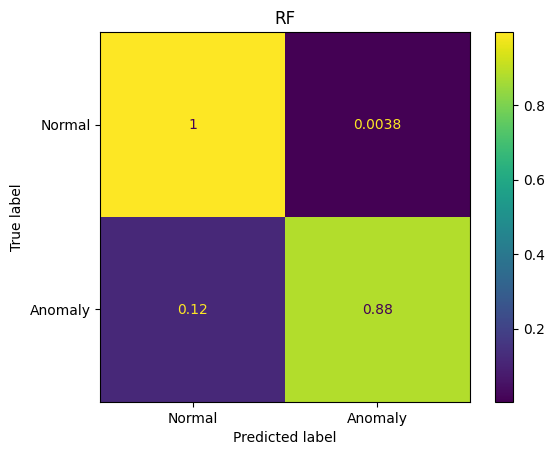

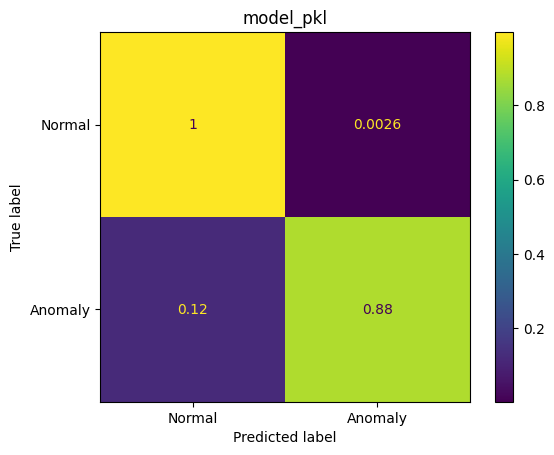

In [26]:
test_model = Pipeline_RF
test_model_name = 'RF'

with open(f'../Docker/data/{test_model_name}_model.pkl', 'rb') as f:
    model_pkl = pickle.load(f)

X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_label, train_size=20000, test_size=100000, random_state=22, stratify= Attack_type)

test_model.fit(X_train, Y_train)

# Testing
Y_pred = test_model.predict(X_test)
print(evaluate_bin(test_model_name, Y_test, Y_pred))

Y_pred = model_pkl.predict(X_test)
print(evaluate_bin('model_pkl', Y_test, Y_pred))